<a href="https://colab.research.google.com/github/rrsguim/PhD_Economics/blob/master/OutputGap_Linear_US.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

------------------------------------------------------------------------------------------------------
Copyright (c) 2020 Rafael Guimaraes

This work was done when I was at the University of California, Riverside, USA. 

It is part of my doctoral thesis in Economics at the Federal University of 

Rio Grande do Sul, Porto Alegre, Brazil.


See full material at https://github.com/rrsguim/PhD_Economics

The code below, under the Apache License, was inspired by

*Classification on imbalanced data*, and 

*Introduction to the Keras Tuner*

Copyright 2020 The TensorFlow Authors

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

https://www.tensorflow.org/tutorials/keras/keras_tuner

-------------------------------------------------------------------------

# Transfer Learning for Output Gap Estimation

##Setup

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
!pip install -U keras-tuner

     |████████████████████████████████| 71kB 4.9MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=fcfa8e5cd14161a7472e2b9a089da4ae5f4028940678847c03be7cb6961a4f1a
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=6626ad744e657d594aab1500c8b77e1fa53a7d3913ef378e866ac9b03325d5b2
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
import tensorflow as tf
from tensorflow import keras

import IPython

import kerastuner as kt
from kerastuner import RandomSearch

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Deep Learning | United States

###Data loading and pre-processing

#### Download the data set

##### The Dataset

We use FRED Economic Data, provided by the Federal Reserve Bank of Saint Louis. Each row in the CSV file corresponds to a quarter, and each column describes an attribute. We will use this information to estimate the output gap.

Following is a description of this dataset. Notice that there are both numeric and categorical columns. All data refer to United States of America from 1967Q1 to 2020Q3.

>Column| Source| Description| Feature Type | Data Type
>------------|--------------------|----------------------|-----------------|----------------
>Unemployment | FRED-MD | UNRATE - Unemployment rate, percent, s.a., quarterly average | Numerical | float
>Capacity | FRED-MD | TCU - Capacity utilization index, percent, s.a., quarterly average | Numerical | float
>Business cycle | FRED-MD | USRECQ - NBER based Recession Indicator (1 = true; 0 = false) | Classification | integer
>Potential GDP | FRED-MD | GDPPOT - Real potential gross domestic product, US billions dollars, quarterly | Numerical | float
>Real GDP | FRED-MD | GDPC1 - Real gross domestic product, s.a., US billions dollars, quarterly | Numerical | float
>Target |  | = ( RealGDP - PotentialGDP ) / RealGDP * 100, percent | Numerical | float

In [ ]:
file = tf.keras.utils
raw_data = pd.read_csv('https://raw.githubusercontent.com/rrsguim/PhD_Economics/master/TL4OG/TL4OG_US_data.csv')

In [ ]:
raw_data.index = raw_data['DATE']
drop_DATE = raw_data.pop('DATE')
raw_data.index = pd.to_datetime(raw_data.index,infer_datetime_format=True)
raw_data.index = raw_data.index.to_period("Q")

Observe last lines of the adjusted dataset.

In [ ]:
raw_data.tail()

,unrate,tcu,NBER,GAP
DATE,,,,
2019Q3,3.60,77.57,0,1.04
2019Q4,3.60,77.24,0,1.17
2020Q1,3.80,75.79,0,-0.55
2020Q2,13.07,65.97,1,-10.99
2020Q3,8.80,72.14,1,-3.68


#### Inspect pre-processed data

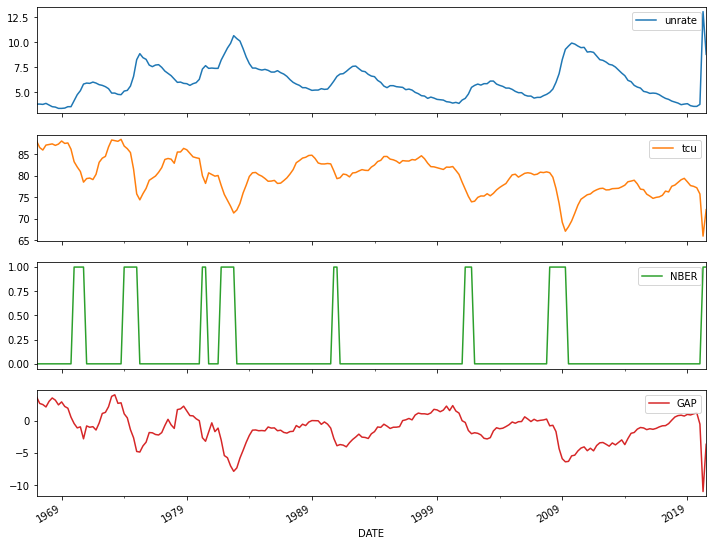

In [ ]:
plot_cols = ['unrate', 'tcu', 'NBER', 'GAP'] 
plot_features = raw_data[plot_cols]
plot_features.index = raw_data.index
_ = plot_features.plot(subplots=True)

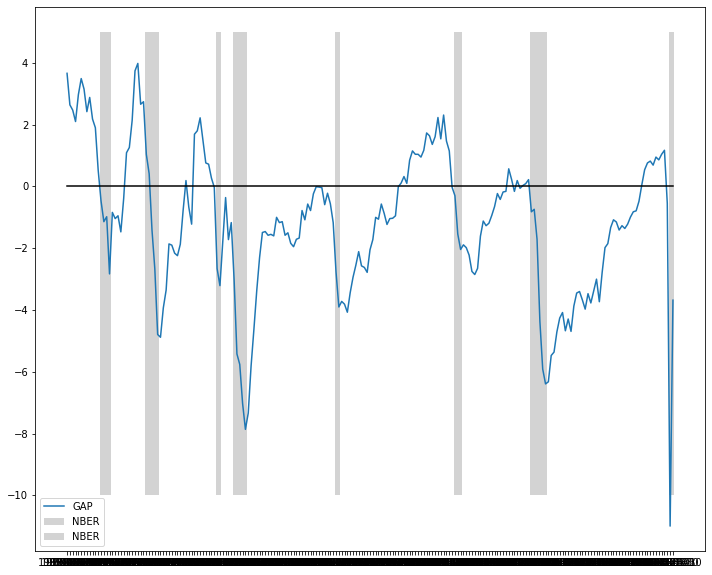

In [ ]:
plt.plot(drop_DATE, raw_data['GAP'], label='GAP')
plt.bar(drop_DATE, raw_data['NBER']*-10 , width=1, linewidth=1, align='center', color="lightgray", label='NBER') 
plt.bar(drop_DATE, raw_data['NBER']*5 , width=1, linewidth=1, align='center', color="lightgray", label='NBER') 
plt.plot(drop_DATE, np.zeros(drop_DATE.shape[0]), color='black')
plt.legend()
plt.show()

In [ ]:
raw_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unrate,215.0,6.091907,1.730741,3.40,4.850,5.73,7.230,13.07
tcu,215.0,80.094558,4.292762,65.97,77.105,80.28,83.330,88.53
NBER,215.0,0.134884,0.342397,0.00,0.000,0.00,0.000,1.00
GAP,215.0,-1.182651,2.345025,-10.99,-2.595,-1.06,0.225,3.98


#### Split and shuffle

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however, the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. 

In [ ]:
# Use a utility from sklearn to split our dataset.
train_df, test_df = train_test_split(raw_data, test_size=0.2, random_state=0)  #
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=0) 
print(len(train_df), 'train examples')
print(len(val_df), 'validation examples')
print(len(test_df), 'test examples') 



137 train examples
35 validation examples
43 test examples


#### Normalize

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.


In [ ]:
#NBER is a dummy, so we don't normalize it. We also don't normalize the target (GAP)
NBER_train = train_df.pop('NBER')
GAP_train = train_df.pop('GAP')
NBER_val = val_df.pop('NBER')
GAP_val = val_df.pop('GAP')
NBER_test = test_df.pop('NBER')
GAP_test = test_df.pop('GAP')

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

#put NBER and GAP back
train_df['NBER'] = NBER_train
train_df['GAP'] = GAP_train
val_df['NBER'] = NBER_val
val_df['GAP'] = GAP_val
test_df['NBER'] = NBER_test
test_df['GAP'] = GAP_test

#### Split features from labels

In [ ]:
# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('GAP'))
val_labels = np.array(val_df.pop('GAP'))
test_labels = np.array(test_df.pop('GAP'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

### Linear model

Create, compile, and train a linear model.

A layers.Dense with no activation set is a linear model. The layer only transforms the last axis of the data from (batch, time, inputs) to (batch, time, units), it is applied independently to every item across the batch and time axes.

In [ ]:
# Model
def build_model():

  model = keras.Sequential()
  model.add(keras.layers.Dense(units=1))
     
  model.compile(loss=keras.losses.MeanSquaredError(), 
                optimizer=keras.optimizers.Adam(),
                metrics=[keras.metrics.MeanAbsoluteError()])
 
  return model

linear_model = build_model()

In [ ]:
MAX_EPOCHS = 500

history_linear = linear_model.fit(train_features, train_labels, 
                    epochs=MAX_EPOCHS,
                    validation_split = 0.2)
                    #validation_data=val_features) 

Epoch 1/500
4/4 [==============================] - 1s 152ms/step - loss: 2.6051 - mean_absolute_error: 1.3488 - val_loss: 3.6144 - val_mean_absolute_error: 1.5311
Epoch 2/500
4/4 [==============================] - 0s 13ms/step - loss: 2.7962 - mean_absolute_error: 1.3817 - val_loss: 3.5951 - val_mean_absolute_error: 1.5264
Epoch 3/500
4/4 [==============================] - 0s 14ms/step - loss: 2.5171 - mean_absolute_error: 1.3102 - val_loss: 3.5757 - val_mean_absolute_error: 1.5217
Epoch 4/500
4/4 [==============================] - 0s 14ms/step - loss: 2.5250 - mean_absolute_error: 1.2980 - val_loss: 3.5565 - val_mean_absolute_error: 1.5170
Epoch 5/500
4/4 [==============================] - 0s 17ms/step - loss: 2.3747 - mean_absolute_error: 1.2822 - val_loss: 3.5375 - val_mean_absolute_error: 1.5123
Epoch 6/500
4/4 [==============================] - 0s 15ms/step - loss: 2.7007 - mean_absolute_error: 1.3703 - val_loss: 3.5177 - val_mean_absolute_error: 1.5074
Epoch 7/500
4/4 [==========

The layer's weights to see the weight assigned to each input:

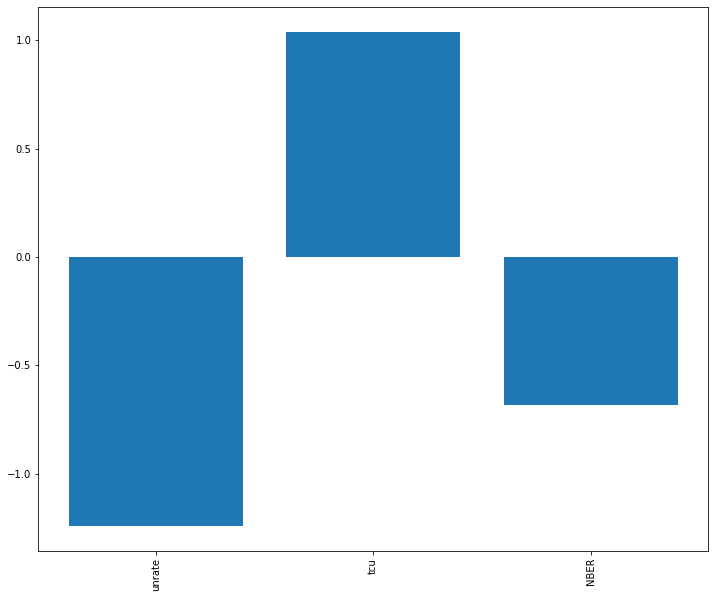

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear_model.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

#### Results

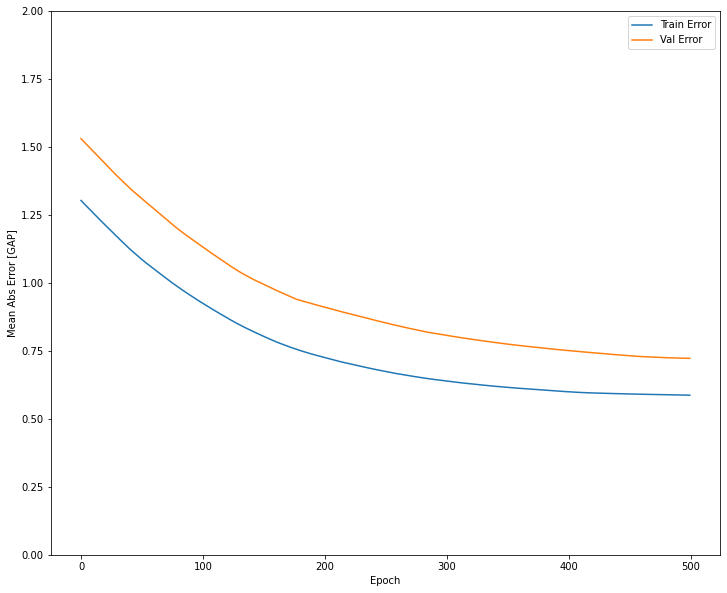

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [GAP]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,2])
  plt.legend()

  plt.show()


plot_history(history_linear)

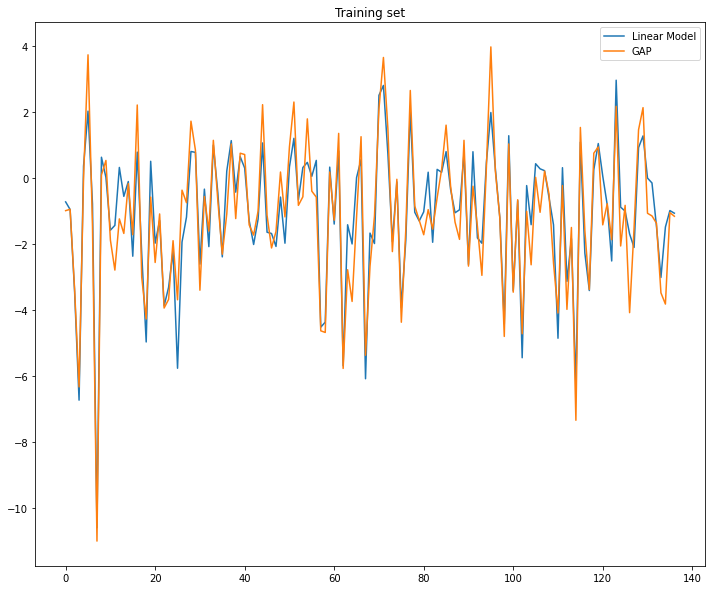

In [ ]:
time_axis_train = range(0,train_labels.shape[0]) # Training set
plt.title('Training set')
plt.plot(time_axis_train, linear_model.predict(train_features).flatten(), label='Linear Model')
plt.plot(time_axis_train, train_labels, label='GAP')
plt.legend()
plt.show()

In [ ]:
train_error = linear_model.predict(train_features).flatten() - train_labels
MAE_train_set = np.sum(np.abs(train_error))/train_error.shape
MAE_train_set

array([0.61485634])

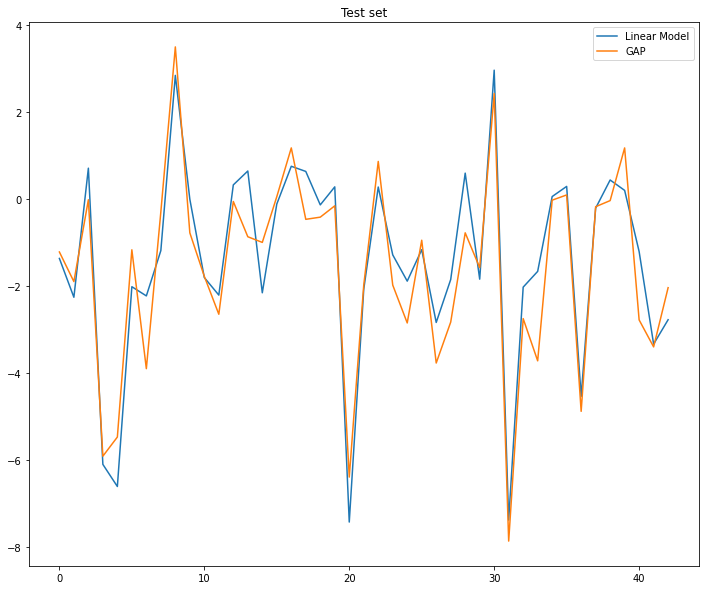

In [ ]:
linear_model_testSet = linear_model.predict(test_features).flatten()
time_axis_test = range(0,test_labels.shape[0]) #Test set
plt.title('Test set')
plt.plot(time_axis_test, linear_model_testSet, label='Linear Model')
plt.plot(time_axis_test, test_labels, label='GAP')
plt.legend()
plt.show()

MAE test set

In [ ]:
test_error = linear_model_testSet - test_labels
MAE_test_set = np.sum(np.abs(test_error))/test_error.shape
MAE_test_set

array([0.66775771])